# Indian abssum with xssum, kagglref https://www.kaggle.com/code/sebastianpetrik/text-summarization-with-seq2seq-model-seb-notes

## XSum setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
# XSum dataset loading is currently broken - using local drive copy
from google.colab import drive
drive.mount('/content/drive')
%ls /content/drive/MyDrive/Datasets/xsum

Mounted at /content/drive
predict.csv  test.csv  train.csv  valid.csv


In [4]:
xsum_train = pd.read_csv('/content/drive/MyDrive/Datasets/xsum/train.csv')
xsum_test = pd.read_csv('/content/drive/MyDrive/Datasets/xsum/test.csv')
xsum_val = pd.read_csv('/content/drive/MyDrive/Datasets/xsum/valid.csv')

xsum_combined = pd.concat([xsum_train, xsum_test, xsum_val])
xsum_combined

,input,target
0,The problem is affecting people using the olde...,Sony has told owners of older models of its Pl...
1,Knight was shot in the leg by an unknown gunma...,Hip hop star Kanye West is being sued by Death...
2,The researchers have sequenced the genome of a...,A team of UK scientists hopes to shed light on...
3,The former army paratrooper first came to prom...,"Hugo Chavez, who won another six-year term as ..."
4,The first-time observation was made on 24 Them...,Scientists have detected water-ice on the surf...
...,...,...
11322,Their comments follow Mrs May's claim she was ...,Some Conservative backbenchers have said they ...
11323,The 27-year-old was a key part of the Foxes si...,Chelsea have signed midfielder Danny Drinkwate...
11324,European football's governing body introduced ...,Uefa has opened a formal investigation into Pa...
11325,"The Spaniard, 31, lost the first set but fough...",Top seed Rafael Nadal overcame stubborn resist...


In [5]:
xsum_combined.rename(columns={"input": "text", "target": "summary"}, inplace=True)
xsum_combined

,text,summary
0,The problem is affecting people using the olde...,Sony has told owners of older models of its Pl...
1,Knight was shot in the leg by an unknown gunma...,Hip hop star Kanye West is being sued by Death...
2,The researchers have sequenced the genome of a...,A team of UK scientists hopes to shed light on...
3,The former army paratrooper first came to prom...,"Hugo Chavez, who won another six-year term as ..."
4,The first-time observation was made on 24 Them...,Scientists have detected water-ice on the surf...
...,...,...
11322,Their comments follow Mrs May's claim she was ...,Some Conservative backbenchers have said they ...
11323,The 27-year-old was a key part of the Foxes si...,Chelsea have signed midfielder Danny Drinkwate...
11324,European football's governing body introduced ...,Uefa has opened a formal investigation into Pa...
11325,"The Spaniard, 31, lost the first set but fough...",Top seed Rafael Nadal overcame stubborn resist...


DF shape:  (226677, 2)


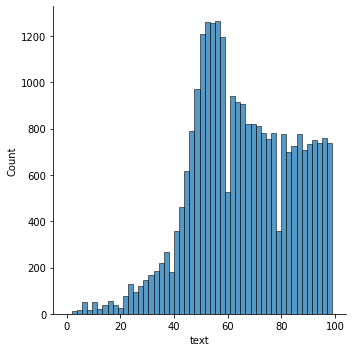

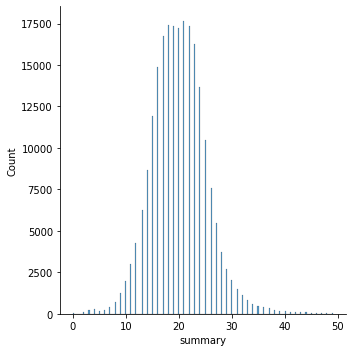

In [6]:
def byspaces_analysis(df):
  print('DF shape: ', df.shape)

  ilen = df['text'].str.count(' ')
  tlen = df['summary'].str.count(' ')
  sns.displot(ilen[ilen < 100])
  sns.displot(tlen[tlen < 50])

  return ilen, tlen

ilen, tlen = byspaces_analysis(xsum_combined)

DF shape:  (48209, 2)


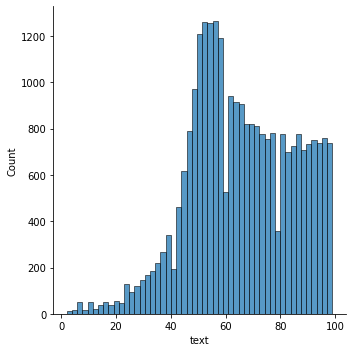

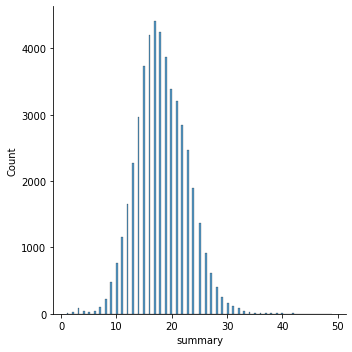

In [7]:
xsum_selected = xsum_combined[(ilen <= 150) & (ilen >= 1) & (tlen >= 1) & (tlen <= 50)]
ilens, tlens = byspaces_analysis(xsum_selected)

In [8]:
xsum_selected

,text,summary
31,The National Oceanic and Atmospheric Administr...,As many as 14 hurricanes could hit the Atlanti...
48,It was a rare example of the Cold War turning ...,"In 1950, as the international community was co..."
49,"The singer and X Factor judge cited ""unreasona...",Cheryl Cole has filed for divorce from footbal...
72,"Ofcom said they had received ""a handful"" of co...",Complaints about Britain's Got Talent are bein...
85,Napper was linked to a series of rapes and att...,Serial rapist Robert Napper was brought to the...
...,...,...
11301,The New Zealand racer set the fastest time of ...,Bruce Anstey again set the pace in the third q...
11306,City paid their Premier League counterparts £2...,Swansea City are close to securing the return ...
11309,Media playback is not supported on this device...,England's hopes of defending their EuroHockey ...
11311,The chorus of Taylor's new single Look What Yo...,Right Said Fred have been credited as writers ...


In [9]:
pre = xsum_selected.reset_index(drop=True)
pre

,text,summary
0,The National Oceanic and Atmospheric Administr...,As many as 14 hurricanes could hit the Atlanti...
1,It was a rare example of the Cold War turning ...,"In 1950, as the international community was co..."
2,"The singer and X Factor judge cited ""unreasona...",Cheryl Cole has filed for divorce from footbal...
3,"Ofcom said they had received ""a handful"" of co...",Complaints about Britain's Got Talent are bein...
4,Napper was linked to a series of rapes and att...,Serial rapist Robert Napper was brought to the...
...,...,...
48204,The New Zealand racer set the fastest time of ...,Bruce Anstey again set the pace in the third q...
48205,City paid their Premier League counterparts £2...,Swansea City are close to securing the return ...
48206,Media playback is not supported on this device...,England's hopes of defending their EuroHockey ...
48207,The chorus of Taylor's new single Look What Yo...,Right Said Fred have been credited as writers ...


**Seq2Seq LSTM Modelling**
![final.jpg](attachment:final.jpg)

In [10]:
#LSTM with Attention
!pip install keras-self-attention

pre['text'][:10]



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=6e3585ea318e6676a42f630d949f17991ec9fd7d748b3a227988cf8597a1a8fa
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


0    The National Oceanic and Atmospheric Administr...
1    It was a rare example of the Cold War turning ...
2    The singer and X Factor judge cited "unreasona...
3    Ofcom said they had received "a handful" of co...
4    Napper was linked to a series of rapes and att...
5    The 74-year-old Vienna State Opera musical dir...
6    Members of the Formartine area committee met i...
7    Three people died in January 2005 when 175mm o...
8    Surrey Fire and Rescue Service was called to t...
9    Marden Henge has been almost destroyed by plou...
Name: text, dtype: object

> **Perform Data Cleansing**

In [11]:
import re

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row




In [12]:
brief_cleaning1 = text_strip(pre['text'])
brief_cleaning2 = text_strip(pre['summary'])

In [13]:
from time import time
import spacy
spacy.prefer_gpu()

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:
#If data loss seems to be happening(i.e len(text) = 50 instead of 75 etc etc) in this cell , decrease the batch_size parametre 

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(brief_cleaning1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value ['ner', 'parser'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


Time to clean up everything: 2.83 mins


In [14]:
#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:


t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.88 mins


In [15]:
text[0]

'the national oceanic and atmospheric administration noaa forecasts 14 to 23 named storms eight to 14 of these could develop into hurricanes it says.the season could be one of the most active on record with between three to seven major hurricanes the noaa said in short we urge everyone to be prepared added spokesperson for the agency said.major hurricanes can reach category three or higher which means they bring sustained winds of at least 111mph 178km/h .the noaa says the seasonal forecasts have 70% probability.the hurricane season begins on june and runs until the end of november.'

In [16]:
summary[0]

'_START_ as many as 14 hurricanes could hit the atlantic basin this year the top us climate agency says. _END_'

In [17]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

In [18]:
text_count = []
summary_count = []

In [19]:
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [20]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

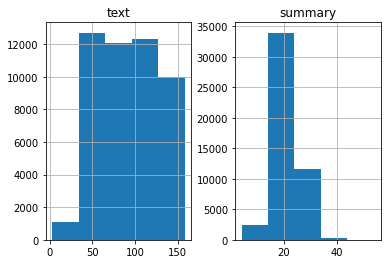

In [21]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [22]:
#Check how much % of summary have max X words
cnt=0
for i in pre['cleaned_summary']:
    if(len(i.split())<=50):
        cnt=cnt+1
print(cnt/len(pre['cleaned_summary']))

0.9999792569852103


In [23]:
#Check how much % of text have max X words
cnt=0
for i in pre['cleaned_text']:
    if(len(i.split())<150):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

0.9918687382024104


In [24]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=150
max_summary_len=50

In [25]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [26]:
post_pre.head(2)

,text,summary
0,the national oceanic and atmospheric administr...,_START_ as many as 14 hurricanes could hit the...
1,it was rare example of the cold war turning ho...,_START_ in 1950 as the international community...


In [27]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')


In [28]:
post_pre.head(2)

,text,summary
0,the national oceanic and atmospheric administr...,sostok _START_ as many as 14 hurricanes could ...
1,it was rare example of the cold war turning ho...,sostok _START_ in 1950 as the international co...


**SEQ2SEQ MODEL BUILDING **

Split the data to TRAIN and VALIDATION sets

In [29]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [30]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

**RARE WORD ANALYSIS FOR X i.e 'text'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [31]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 63.383132872431105
Total Coverage of rare words: 1.9008429752383218


In [32]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 30932


**RARE WORD ANALYSIS FOR Y i.e 'summary'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [33]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [34]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 73.60875073386275
Total Coverage of rare words: 4.367686488532698


In [35]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 8542


We will now remove "Summary" i.e Y (both train and val) which has only _START_ and _END_

In [36]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [37]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [57]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Size of vocabulary from the w2v model = 30932


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 150, 200)     6186400     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 150, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [58]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [46]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


**Start fitting the model with the data**

In [55]:
# checkpoint_filepath = '/content/drive/MyDrive/checkpoint.weights.{epoch:02d}-{val_loss:.2f}.hdf'
checkpoint_filepath = '/content/drive/MyDrive/checkpoint.best.hdf'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [49]:
#@markdown #**Anti-Disconnect for Google Colab**
#@markdown ## Run this to stop it from disconnecting automatically 
#@markdown  **(It will anyhow disconnect after 6 - 12 hrs for using the free version of Colab.)**
#@markdown  *(Colab Pro users will get about 24 hrs usage time)*
#@markdown ---

import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

In [60]:
try:
  model.load_weights(checkpoint_filepath)
  print('Loaded model checkpoint.')
except:
  print('Cannot load weights from checkpoint, it may not exist yet.')

Loaded model checkpoint.


In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es, model_checkpoint_callback],
    batch_size=256,
    validation_data=(
        [x_val, y_val[:, :-1]],
        y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:],
    ),
)

Epoch 1/50
 64/169 [==========>...................] - ETA: 4:01 - loss: 2.0502

**Visualize the model learning**

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Next, let’s build the dictionary to convert the index to word for target and source vocabulary:**

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

**We are defining a function below which is the implementation of the inference process**

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

**Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:**


In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

**Run the model over the data to see the results**

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")